## Training For Nature Communications

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import keras_nlp
from keras import regularizers
from keras.callbacks import History 
history = History()
np.set_printoptions(precision=4, suppress=True)
tf.config.set_visible_devices([], 'GPU') # Disable GPU Usage
print("TensorFlow version:", tf.__version__)

/Users/bobby/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Using TensorFlow backend
TensorFlow version: 2.15.0


In [2]:
# Load data
arr = np.loadtxt("./training.csv", delimiter=",")
x = arr[:,0:8]
y = arr[:,8:]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print('Training Input Shape: ', x_train.shape)
print('Training Output Shape: ', y_train.shape)
print('Testing Input Shape: ', x_test.shape)
print('Testing Output Shape: ', y_test.shape)

Training Input Shape:  (1600, 8)
Training Output Shape:  (1600, 3)
Testing Input Shape:  (400, 8)
Testing Output Shape:  (400, 3)


In [3]:
# Flipping the training samples that have \Delta y > 0
training_size = len(x_train)
x_train_processed = x_train.copy()
y_train_processed = y_train.copy()

for i in range(training_size):
    if x_train[i, 7] > 0:
        x_train_processed[i, 1] = -1 * x_train[i, 1] # Flip obstacle y-coordinates
        x_train_processed[i, 5] = -1 * x_train[i, 5] # Flip receiver y-coordinates
        x_train_processed[i, 7] = -1 * x_train[i, 7] # Flip \Delta y
        y_train_processed[i, 0] = -1 * y_train[i, 0] # Flip curving parameter
        y_train_processed[i, 2] = -1 * y_train[i, 2] # Flip steering adjustment

# Normalization of training data (recording the mean and standard deviation)
xmean = x_train_processed.mean(0)
xstd = x_train_processed.std(0)
x_train_processed -= xmean
x_train_processed /= xstd
ymean = y_train_processed.mean(0)
ystd = y_train_processed.std(0)
y_train_processed -= ymean
y_train_processed /= ystd

In [4]:
# Similarly, preprocess the test samples
testing_size = len(x_test)
x_test_processed = x_test.copy()
y_test_processed = y_test.copy()

for i in range(testing_size):
    if x_test[i, 7] > 0:
        x_test_processed[i, 1] = -1 * x_test_processed[i, 1] # Flip obstacle y-coordinates
        x_test_processed[i, 5] = -1 * x_test_processed[i, 5] # Flip receiver y-coordinates
        x_test_processed[i, 7] = -1 * x_test_processed[i, 7] # Flip \Delta y
        y_test_processed[i, 0] = -1 * y_test_processed[i, 0] # Flip curving parameter
        y_test_processed[i, 2] = -1 * y_test_processed[i, 2] # Flip steering adjustment

# Normalization of testing data (using mean and std learned from the training set)
x_test_processed -= xmean
x_test_processed /= xstd
y_test_processed -= ymean
y_test_processed /= ystd

In [5]:
# Linear best model

model = tf.keras.models.Sequential([
  # tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L1(0.0001)),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(3)
])
model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.008, momentum=0.8),
              loss=tf.keras.losses.MeanAbsoluteError())
history = model.fit(x_train_processed, y_train_processed, batch_size=64, epochs=1000, validation_data=(x_test_processed, y_test_processed))

Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.7543 - val_loss: 0.6896
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.7099 - val_loss: 0.6503
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.6761 - val_loss: 0.6244
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.6510 - val_loss: 0.6005
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.6284 - val_loss: 0.5741
Epoch 6/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.5983 - val_loss: 0.5441
Epoch 7/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.5747 - val_loss: 0.5136
Epoch 8/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.5531 - val_loss: 0.4913
Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.5359 - val_loss: 0.4770
Epoch 10/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.5253 - val_loss: 0.4678

In [23]:
# model.save('physicalBest.keras')

model = tf.keras.models.load_model('modelParam.keras')
model.summary()

# np.savetxt("y_pred1.csv", y_pred, delimiter=",")
# np.savetxt("y_test1.csv", y_test, delimiter=",")
# np.savetxt("x_test1.csv", x_test, delimiter=",")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 512)               4608      
                                                                 
 dropout_24 (Dropout)        (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 512)               262656    
                                                                 
 dropout_25 (Dropout)        (None, 512)               0         
                                                                 
 dense_34 (Dense)            (None, 512)               262656    
                                                                 
 dropout_26 (Dropout)        (None, 512)               0         
                                                                 
 dense_35 (Dense)            (None, 3)                

In [24]:
y_pred = model.predict(x_test_processed)
y_pred_tr = model.predict(x_train_processed)

50/50 [==============================] - 0s 834us/step


In [25]:
# Unnormalize data
y_pred = y_pred * ystd
y_pred = y_pred + ymean
y_pred_tr = y_pred_tr * ystd
y_pred_tr = y_pred_tr + ymean

for i in range(testing_size):
    if x_test[i, 7] > 0:
        y_pred[i, 0] = -1 * y_pred[i, 0] # Flip curving parameter
        y_pred[i, 2] = -1 * y_pred[i, 2] # Flip steering adjustment

for i in range(training_size):
    if x_train[i, 7] > 0:
        y_pred_tr[i, 0] = -1 * y_pred_tr[i, 0] # Flip curving parameter
        y_pred_tr[i, 2] = -1 * y_pred_tr[i, 2] # Flip steering adjustment

R2 score:  0.3595591036369804
All R2:  0.3595591036369804 0.7470697630922836 0.9480358579365924
Total R2:  2.0546647246658565


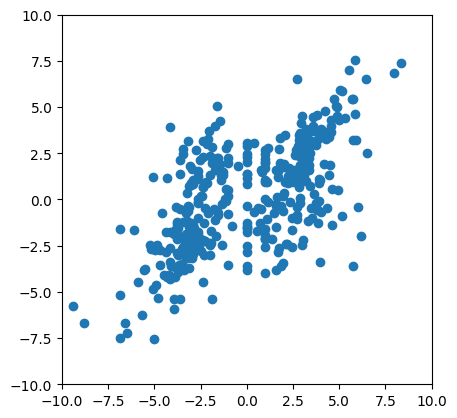

In [26]:
ind = 0
plt.scatter(y_test[:,ind], y_pred[:,ind])
plt.axis('square')
plt.xlim([-10, 10])
plt.ylim([-10, 10])
print('R2 score: ', r2_score(y_test[:,ind],y_pred[:,ind]))
print('All R2: ', r2_score(y_test[:,0],y_pred[:,0]), r2_score(y_test[:,1],y_pred[:,1]), r2_score(y_test[:,2],y_pred[:,2]))
print('Total R2: ', r2_score(y_test[:,0],y_pred[:,0]) + r2_score(y_test[:,1],y_pred[:,1]) + r2_score(y_test[:,2],y_pred[:,2]))

R2 score:  0.7163047701761462


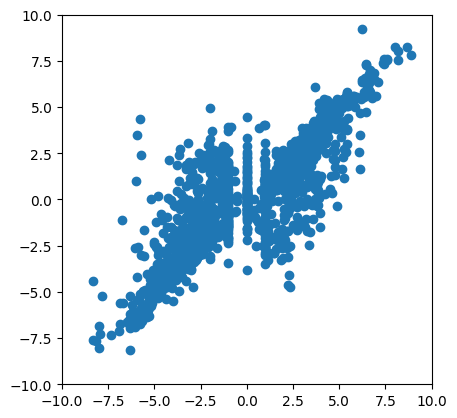

In [27]:
plt.scatter(y_train[:,0], y_pred_tr[:,0])
plt.axis('square')
plt.xlim([-10, 10])
plt.ylim([-10, 10])
print('R2 score: ',r2_score(y_train[:,0],y_pred_tr[:,0]))

(array([ 0.,  0.,  3.,  3.,  7., 10., 26., 61., 43., 45., 36., 66., 41.,
        34., 11.,  8.,  4.,  2.,  0.,  0.]),
 array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
          1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <BarContainer object of 20 artists>)

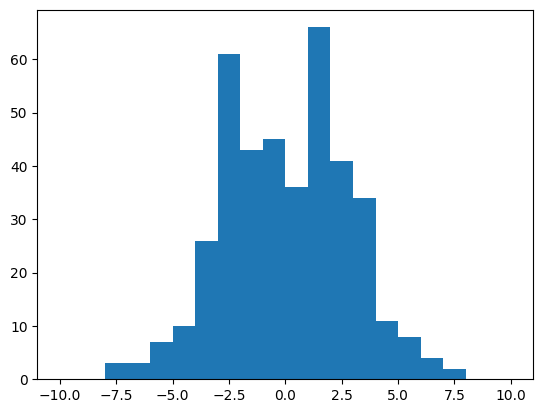

In [28]:
plt.hist(y_pred[:,0], bins=20, range=(-10,10))

(array([ 1.,  1.,  0.,  6.,  8., 21., 59., 53., 34.,  9., 27., 41., 48.,
        53., 20., 13.,  4.,  1.,  1.,  0.]),
 array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
          1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <BarContainer object of 20 artists>)

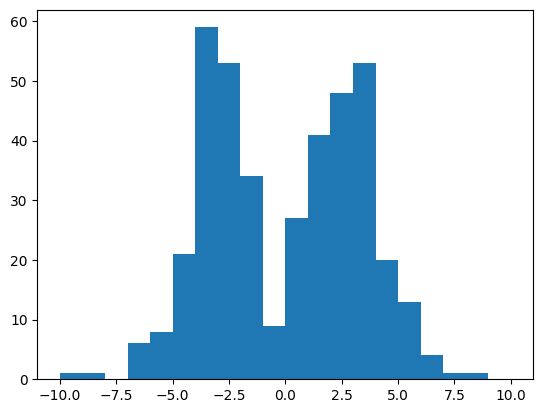

In [29]:
plt.hist(y_test[:,0], bins=20, range=(-10,10))

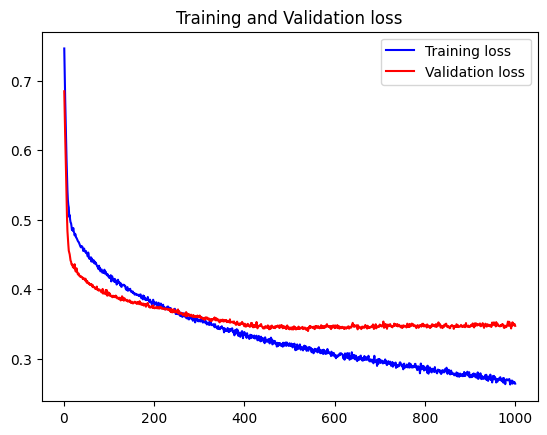

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

## For Manual Testing of Neural Network

In [36]:
model = tf.keras.models.load_model('modelParam.keras')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 512)               4608      
                                                                 
 dropout_24 (Dropout)        (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 512)               262656    
                                                                 
 dropout_25 (Dropout)        (None, 512)               0         
                                                                 
 dense_34 (Dense)            (None, 512)               262656    
                                                                 
 dropout_26 (Dropout)        (None, 512)               0         
                                                                 
 dense_35 (Dense)            (None, 3)                

In [37]:
# For manual testing individual cases
manual_test = np.array([0.15, -0.06, 0.02, 0.08, 0.3, -0.08, 0.74129, 0.04])
manual_test = np.reshape(manual_test, (1,8))

In [38]:
manual_test_processed = manual_test.copy()
if manual_test[0][7] > 0:
        manual_test_processed[0][1] = -1 * manual_test_processed[0][1] # Flip obstacle y-coordinates
        manual_test_processed[0][5] = -1 * manual_test_processed[0][5] # Flip receiver y-coordinates
        manual_test_processed[0][7] = -1 * manual_test_processed[0][7] # Flip \Delta y
manual_test_processed -= xmean
manual_test_processed /= xstd
manual_pred = model.predict(manual_test_processed)
manual_pred = manual_pred * ystd
manual_pred = manual_pred + ymean
if manual_test[0][7] > 0:
        manual_pred[0][0] = -1 * manual_pred[0][0] # Flip curving parameter
        manual_pred[0][2] = -1 * manual_pred[0][2] # Flip steering adjustment

1/1 [==============================] - 0s 35ms/step


In [39]:
manual_pred

array([[ 4.3626, -0.1588,  8.6781]])